In [1]:
import sys, os, pickle, time, json, yaml, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import numpy as np
import pandas as pd
import scipy as sp
from array import array
import root_numpy as rtnp
from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from scipy.stats import chi2 as scipy_chi2
from histo_utilities import create_TH1D, make_ratio_plot, create_TH2D, std_color_list, rootTH1_to_np
from pileup_utilities import pileupReweighter
from beamSpot_calibration import doubleCrystalball, getBeamSpotWeights, getBeamSpotCorrectionWeights
from categoriesDef import categories as categoriesDef
donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = 6*' ' + 'Simulation Internal'

In [3]:
category = 'Low'

webDir = os.environ['HOME'] + '/public_html/BPH_RDst/beamSpotCalibration/v1'
if not os.path.isdir(webDir):
    os.makedirs(webDir)
    os.system('cp {d}/../index.php {d}/'.format(d=webDir))

In [5]:
MCsample = {
######## Signals
'mu': DSetLoader('Bd_MuNuDst', candDir='ntuples_B2DstMu_220225'),
'JpsiKst': DSetLoader('Bd_JpsiKst_General', candDir='ntuples_Bd2JpsiKst_220217')
}

df = {}
df['mu'] = pd.DataFrame(rtnp.root2array(MCsample['mu'].skimmed_dir + '/'+category+'_bare.root'))
skimmedFile_loc = MCsample['mu'].skimmed_dir + '/{}_{}.root'.format(category, 'bare')
puReweighter = pileupReweighter(skimmedFile_loc, 'hAllNTrueIntMC', trg=categoriesDef[category.lower()].trg)
df['mu']['w'] = puReweighter.getPileupWeights(df['mu']['MC_nInteractions'])

df['JpsiKst'] = pd.DataFrame(rtnp.root2array(MCsample['JpsiKst'].skimmed_dir + '/'+category+'_bare.root'))
skimmedFile_loc = MCsample['JpsiKst'].skimmed_dir + '/{}_{}.root'.format(category, 'bare')
puReweighter = pileupReweighter(skimmedFile_loc, 'hAllNTrueIntMC', trg=categoriesDef[category.lower()].trg)
df['JpsiKst']['w'] = puReweighter.getPileupWeights(df['JpsiKst']['MC_nInteractions'])

dataLoc = '/storage/af/group/rdst_analysis/BPhysics/data/cmsRD/'
df['data'] = pd.DataFrame(rtnp.root2array(
    dataLoc+'skimmed/B2DstMu_220220_'+category+'_corr.root'))

[pileup reweighting] wMax=5.9, wMin=0.0
[pileup reweighting] wMax=319.8, wMin=0.0


Warning in <TFile::Init>: file /storage/af/group/rdst_analysis/BPhysics/data/PileupHistograms/Mu7_IP4_allParts.root probably not closed, trying to recover
Info in <TFile::Recover>: /storage/af/group/rdst_analysis/BPhysics/data/PileupHistograms/Mu7_IP4_allParts.root, recovered key TH1D:pileup at address 264
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /storage/af/group/rdst_analysis/BPhysics/data/PileupHistograms/Mu7_IP4_allParts.root probably not closed, trying to recover
Info in <TFile::Recover>: /storage/af/group/rdst_analysis/BPhysics/data/PileupHistograms/Mu7_IP4_allParts.root, recovered key TH1D:pileup at address 264
Warning in <TFile::Init>: successfully recovered 1 keys


In [6]:
binning = {}
binning['q2'] = [0, 3.5, 6, 9.4, 12]

negSide = [-2.5, -1.5, -1.0, -0.6, -0.4, -0.2]
binning['M2_miss'] = [
    negSide + [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 4],
    negSide + [0.0, 0.1, 0.2, 0.3] + list(np.arange(0.4, 3.5, 0.2)) + [8],
    negSide + list(np.arange(0, 6, 0.2)) + [8],
    negSide + list(np.arange(0, 7.8, 0.2)) + [8],
]

In [7]:
# Create centered values
for n in ['JpsiKst', 'mu', 'data']:
    for a in ['x', 'y']:
        df[n]['vtxC_'+a] = 1e4*(df[n]['vtx_PV_'+a] - np.mean(df[n]['vtx_PV_'+a]))
        print n, a, np.mean(df[n]['vtx_PV_'+a])

JpsiKst x 0.0107620187498
JpsiKst y 0.0417518580732
mu x 0.0107663120541
mu y 0.0417461945592
data x 0.0964252896599
data y -0.0616805808048


# Draw plots

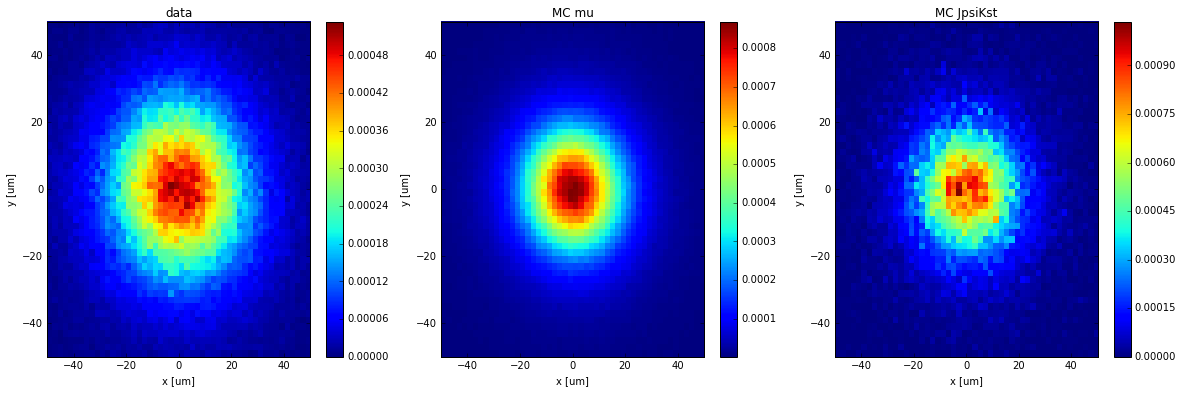

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

bounds = ((-50, 50), (-50, 50))
h = axs[0].hist2d(df['data']['vtxC_x'], df['data']['vtxC_y'], range=bounds, bins=50, normed=True)
axs[0].set_title('data')
fig.colorbar(h[3], ax=axs[0])
h = axs[1].hist2d(df['mu']['vtxC_x'], df['mu']['vtxC_y'], range=bounds, bins=50, normed=True, weights=df['mu']['w'])
axs[1].set_title('MC mu')
fig.colorbar(h[3], ax=axs[1])
h = axs[2].hist2d(df['JpsiKst']['vtxC_x'], df['JpsiKst']['vtxC_y'], range=bounds, bins=50, normed=True, weights=df['JpsiKst']['w'])
axs[2].set_title('MC JpsiKst')
fig.colorbar(h[3], ax=axs[2])
for ax in axs:
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')
fig.savefig(webDir + '/vertex_2D_pre_'+category+'.png', bbox_inches='tight')

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


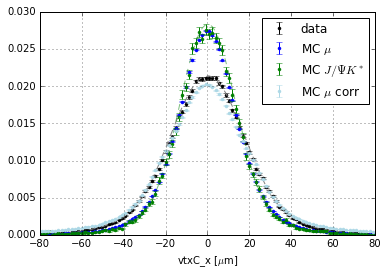

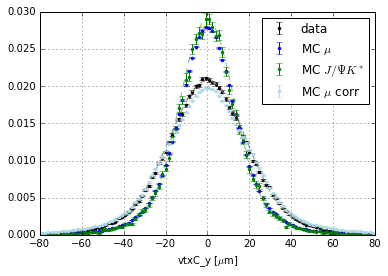

In [9]:
param = {}
bbb = [100, -80, 80]
for n in ['vtxC_x', 'vtxC_y']:
    plt.figure()
    h = create_TH1D(df['data'][n], binning=bbb, scale_histo='norm', widthNorm=True)
    r = rootTH1_to_np(h)
    sData = np.std(df['data'][n])
    parData, cov = sp.optimize.curve_fit(doubleCrystalball, r[:,0], r[:,1], p0=[0, 0.8*sData, 1.5, 1.5], sigma=r[:,2])
    h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', color='k', label='data')
    plt.plot(r[:,0], doubleCrystalball(r[:,0], *parData), color='gray', ls='--')

    h = create_TH1D(df['mu'][n], binning=bbb, weights=df['mu']['w'], scale_histo='norm', widthNorm=True)
    r = rootTH1_to_np(h)
    sMC = np.std(df['mu'][n])
    h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', color='blue', label=r'MC $\mu$')
    
    h = create_TH1D(df['JpsiKst'][n], binning=bbb, weights=df['JpsiKst']['w'], scale_histo='norm', widthNorm=True)
    r = rootTH1_to_np(h)
    sMC = np.std(df['JpsiKst'][n])
    parMC, cov = sp.optimize.curve_fit(doubleCrystalball, r[:,0], r[:,1], p0=[0, 0.8*sMC, 1.5, 1.5], sigma=r[:,2])
    h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', color='green', label=r'MC $J/\Psi K^*$')
    plt.plot(r[:,0], doubleCrystalball(r[:,0], *parMC), color='green', alpha=0.5, ls='--')

    widthCorr = getBeamSpotWeights(df['mu'], n[-1], parData, parMC)
    h = create_TH1D(df['mu'][n], binning=bbb, weights=df['mu']['w']*widthCorr, scale_histo='norm', widthNorm=True)
    r = rootTH1_to_np(h)
    plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', label=r'MC $\mu$ corr', color='lightblue')

    plt.legend(loc='best', numpoints=1)
    plt.xlabel(n + r' [$\mu$m]')
    plt.grid()
    plt.savefig(webDir + '/vertex_1D_'+n[-1]+'_pre_'+category+'.png', bbox_inches='tight')
    
    param[n[-1]] = {'data':parData, 'MC':parMC}

In [10]:
param

{'x': {'MC': array([ 0.23468262, 13.72154271,  1.46613811, 23.75942868]),
  'data': array([ 0.05008929, 18.21613993,  1.52759685, 16.29711028])},
 'y': {'MC': array([-0.08387139, 13.40953229,  1.47093893, 13.51053579]),
  'data': array([ 0.04749138, 18.84382081,  1.56458671, 21.45929883])}}

In [11]:
out = {}
for k in param.keys():
    out[k] = {}
    for kk in param[k].keys():
        out[k][kk] = [float(x) for x in param[k][kk]]
from datetime import datetime
fname = '/storage/af/group/rdst_analysis/BPhysics/data/calibration/beamSpot/crystalball_calibration_v1_'+category+'.yaml'
with open(fname, 'w') as f:
    f.write('# Calibration of beam spot using independent CB approx\n')
    f.write('# pars = [mu, sigma, beta, m]\n')
    f.write('# '+datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '\n')
    f.write(yaml.dump(out))
    
param = yaml.load(open(fname, 'r'))
print param

{'y': {'data': [0.04749138285882041, 18.843820813375448, 1.5645867068252302, 21.45929883042351], 'MC': [-0.08387138515044806, 13.409532285215024, 1.4709389327817002, 13.510535793519605]}, 'x': {'data': [0.05008928856612648, 18.216139927816698, 1.5275968476648545, 16.297110276344757], 'MC': [0.23468261830576684, 13.721542710428443, 1.4661381122714656, 23.759428680081342]}}


In [12]:
df['JpsiKst']['w_width'] = getBeamSpotCorrectionWeights(df['JpsiKst'], param)

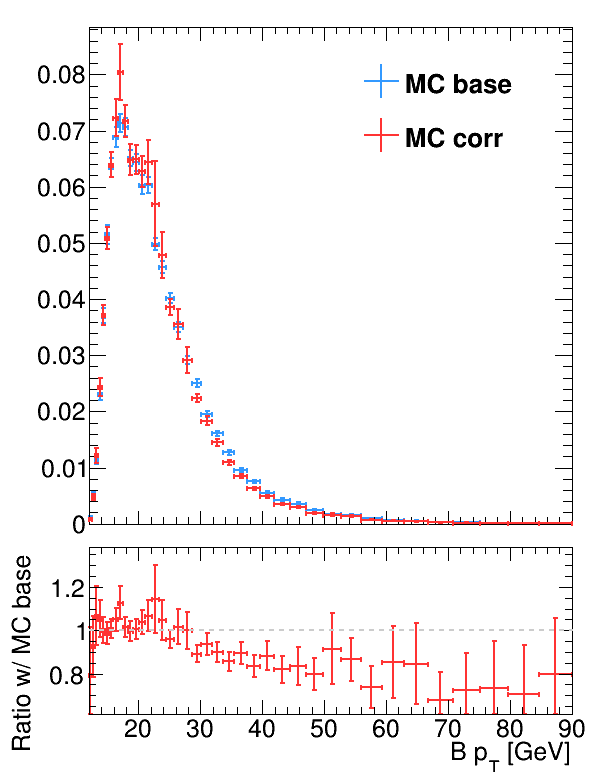

In [13]:
auxDf = df['JpsiKst']
lowOff = 5
midOff = 10
highOff = 5
b = {'Low': array('d', list( lowOff+np.logspace(np.log10(12-lowOff), np.log10(90-lowOff), 40) )),
     'Mid': array('d', list( midOff+np.logspace(np.log10(14-midOff), np.log10(100-midOff), 45) )),
     'High': array('d', list( highOff+np.logspace(np.log10(18-highOff), np.log10(125-highOff), 50) )),
    }

h_base = create_TH1D(auxDf['B_pt'], 'MC base', weights=auxDf['w'], 
                     color=0, binning=b[category], widthNorm=True, scale_histo='norm')

h_corr = create_TH1D(auxDf['B_pt'], 'MC corr', weights=auxDf['w']*auxDf['w_width'],
                     color=1, binning=b[category], widthNorm=True, scale_histo='norm')


h_base.SetXTitle('B p_{T} [GeV]')
c = make_ratio_plot([h_base, h_corr], ratio_bounds='auto', 
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)

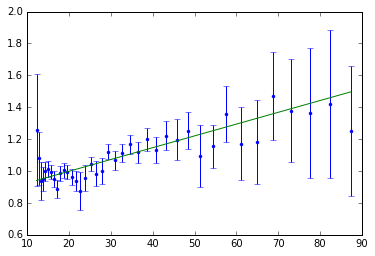

In [14]:
h_ratio = h_base.Clone('h_ratio')
h_ratio.Divide(h_corr)
r = rootTH1_to_np(h_ratio)

h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.')
pt_p = np.polyfit(x=r[:,0], y=r[:,1], deg=1, w=1./r[:,2])
plt.plot(r[:,0], np.polyval(pt_p, r[:,0]), color='green')

In [15]:
df['JpsiKst']['w_pt'] = np.polyval(pt_p, df['JpsiKst']['B_pt'])

Warning in <TROOT::Append>: Replacing existing TH1: MC base (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC corr (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


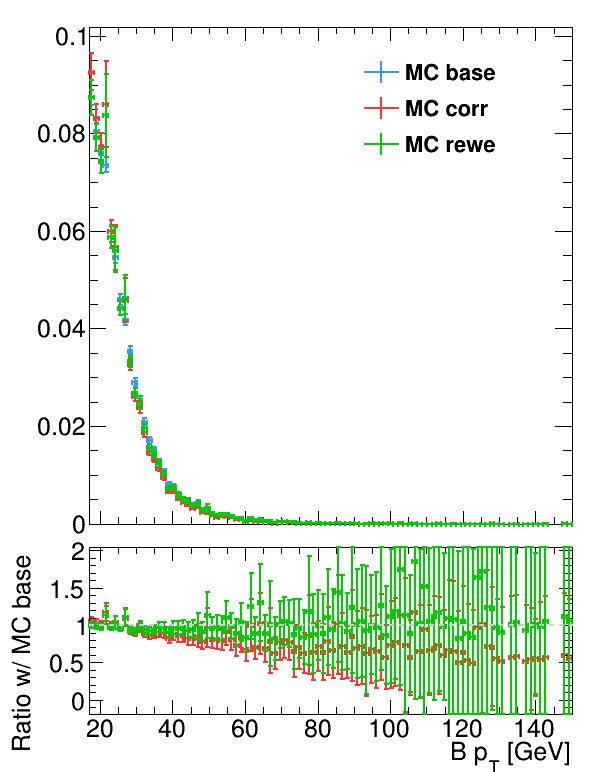

In [16]:
auxDf = df['JpsiKst']
h_base = create_TH1D(auxDf['B_pt'], 'MC base', weights=auxDf['w'], 
                     color=0, binning=[100,17,150], widthNorm=True, scale_histo='norm')

h_corr = create_TH1D(auxDf['B_pt'], 'MC corr', weights=auxDf['w']*auxDf['w_width'],
                     color=1, binning=[100,17,150], widthNorm=True, scale_histo='norm')

h_rewe = create_TH1D(auxDf['B_pt'], 'MC rewe', weights=auxDf['w']*auxDf['w_width']*auxDf['w_pt'],
                     color=2, binning=[100,17,150], widthNorm=True, scale_histo='norm')


h_base.SetXTitle('B p_{T} [GeV]')
c = make_ratio_plot([h_base, h_corr, h_rewe], ratio_bounds='auto', 
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)

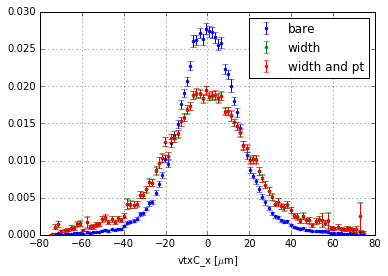

In [17]:
n = 'vtxC_x'
x = df['JpsiKst'][n]

h = create_TH1D(x, binning=[100, -75, 75], weights=df['JpsiKst']['w'], scale_histo='norm', widthNorm=True)
r = rootTH1_to_np(h)
h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', label='bare')

h = create_TH1D(x, binning=[100, -75, 75], weights=df['JpsiKst']['w']*df['JpsiKst']['w_width'], scale_histo='norm', widthNorm=True)
r = rootTH1_to_np(h)
h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', label='width')

h = create_TH1D(x, binning=[100, -75, 75], weights=df['JpsiKst']['w']*df['JpsiKst']['w_width']*df['JpsiKst']['w_pt'], scale_histo='norm', widthNorm=True)
r = rootTH1_to_np(h)
h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', label='width and pt')

plt.legend(loc='best', numpoints=1)
plt.xlabel(n + r' [$\mu$m]')
plt.grid()

# Check effect on missing mass

In [18]:
df['mu']['w_width'] = getBeamSpotCorrectionWeights(df['mu'], param)

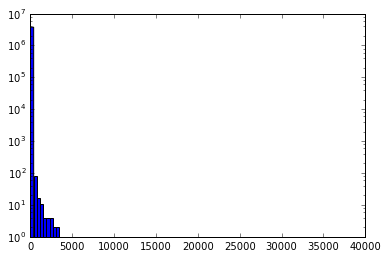

In [22]:
plt.hist(df['mu']['w_width'], bins=100, range=(0,1.1*np.max(df['mu']['w_width'])))
plt.yscale('log')

In [33]:
np.percentile(df['mu']['w_width'], 99.9)

26.779785562097093

In [24]:
print np.sort(df['mu']['w_width'])[-10:]

[ 3512.26073589  3919.30571751  4388.57501288  5947.12139721
  6750.46213903  7089.35273147  7335.07173905  8872.60456122
 14500.14088761 34515.49583866]


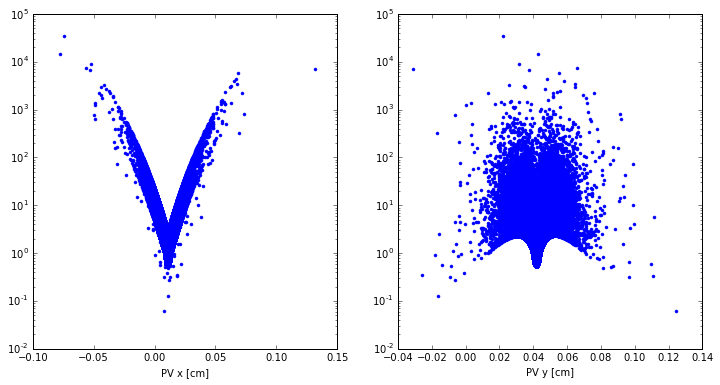

In [28]:
fig, (ax, ay) = plt.subplots(1,2, figsize=(12, 6))

ax.plot(df['mu']['vtx_PV_x'], df['mu']['w_width'], '.')
ax.set_yscale('log')
ax.set_xlabel('PV x [cm]')

ay.plot(df['mu']['vtx_PV_y'], df['mu']['w_width'], '.')
ay.set_yscale('log')
ay.set_xlabel('PV y [cm]')

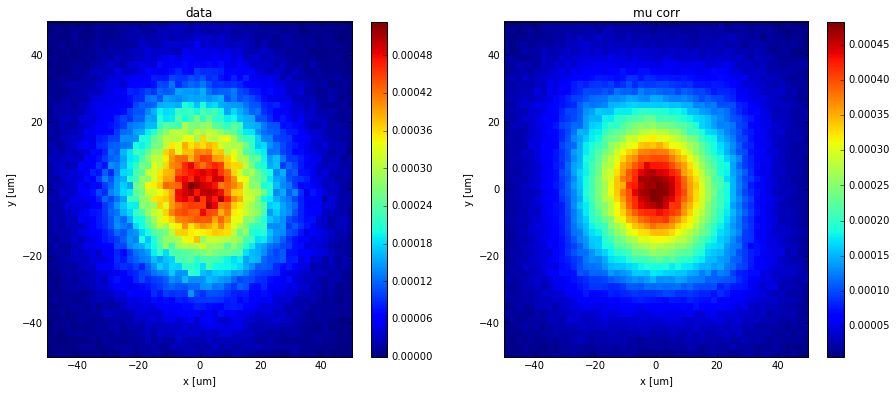

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

bounds = ((-50, 50), (-50, 50))
h = axs[0].hist2d(df['data']['vtxC_x'], df['data']['vtxC_y'], range=bounds, bins=50, normed=True)
fig.colorbar(h[3], ax=axs[0])
h = axs[1].hist2d(df['mu']['vtxC_x'], df['mu']['vtxC_y'], range=bounds, bins=50, normed=True, 
                  weights=df['mu']['w']*df['mu']['w_width'])
fig.colorbar(h[3], ax=axs[1])
axs[0].set_title('data')
axs[1].set_title('mu corr')
for ax in axs:
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')
fig.savefig(webDir + '/vertex_2D_post_'+category+'.png', bbox_inches='tight')

In [ ]:
sel = df['mu']['q2'] < binning['q2'][1]
auxDf = df['mu'][sel]

In [ ]:
h_base = create_TH1D(auxDf['M2_miss'][sel], 'MC base', weights=auxDf['w'], 
                     color=0, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')

h_corr = create_TH1D(auxDf['M2_miss'][sel], 'MC corr', weights=auxDf['w']*auxDf['w_width'],
                     color=1, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')


h_base.SetXTitle('M^{2}_{miss} [GeV]')
c = make_ratio_plot([h_base, h_corr], ratio_bounds=[0.9, 1.1], 
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)

In [ ]:
r = 10
phi = 45 + 90
dx = r*np.cos(np.deg2rad(phi))
dy = r*np.sin(np.deg2rad(phi))

auxW = getBeamSpotCorrectionWeights(auxDf, param, dmu_x=-dx, dmu_y=-dy)
h_xDw = create_TH1D(auxDf['M2_miss'][sel], 'Up', weights=auxDf['w']*auxW,
                    color=0, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')

auxW = getBeamSpotCorrectionWeights(auxDf, param, dmu_x=dx, dmu_y=dy)
h_xUp = create_TH1D(auxDf['M2_miss'][sel], 'Dw', weights=auxDf['w']*auxW,
                    color=1, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')


h_corr = create_TH1D(auxDf['M2_miss'][sel], 'MC corr', weights=auxDf['w']*auxDf['w_width'],
                     color=2, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')


h_base.SetXTitle('M^{2}_{miss} [GeV]')
c = make_ratio_plot([h_corr, h_xDw, h_xUp], ratio_bounds=[0.95, 1.05], 
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)